In [1]:
import pickle 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import glob
import matplotlib as mpl
from matplotlib.pyplot import cm
import matplotlib.ticker as mtick


In [2]:
def load_results(scratch_path, dataset, mode, fairness_method, setting = None):
    if mode == 'BOOST': 
        fmt_path = glob.glob(f'{scratch_path}{dataset}/{mode}/boost2/FMT_AVG_*_{fairness_method}*.xlsx')[0] 
    elif setting == 'T': 
        fmt_path = glob.glob(f'{scratch_path}{dataset}/{mode}/FMT_AVG_*{setting}_{fairness_method}*.xlsx')[0] 
    else:    
        fmt_path = glob.glob(f'{scratch_path}{dataset}/{mode}/FMT_AVG_*_{fairness_method}*.xlsx')[0] 
    
    fmt_data = pd.read_excel(fmt_path)
    
    return fmt_data

def gamma_prep(df, mode): 
    if mode == 'PS': 
        df_slice = pd.concat([df[df.param == 'PinSage'][report]] *9).reset_index(drop=True)
    if mode == 'LGCN': 
        df_slice = pd.concat([df[df.param == 'vanilla'][report]] *9).reset_index(drop=True)
    if mode == 'SR': 
        df_slice = df[report].reset_index(drop=True)
    if mode == 'REDRESS': 
        df_slice = df.loc[df.param != 'PinSage'][report].reset_index(drop=True)
    if mode == 'XQUAD': 
        df_slice = df[report].reset_index(drop=True)
    if mode == 'BOOST':
        df_slice = df.loc[df.param != 'PinSage'][report].reset_index(drop=True)
    
    
    df_slice = df_slice.rename(columns={
        'r_precision': 'recall@100', 
        'competition_ndcg': 'ndcg@100', 
        'artist_prec': 'artist_recall@100', 
        'sound_homogeneity': 'flow', 
        'perc_LT': '%LT_songs', 
        'LT_item_cvg': 'LT_song_coverage', 
        'arid_cvg': 'artist_coverage', 
        'param': 'param_val'
    })
    return df_slice 

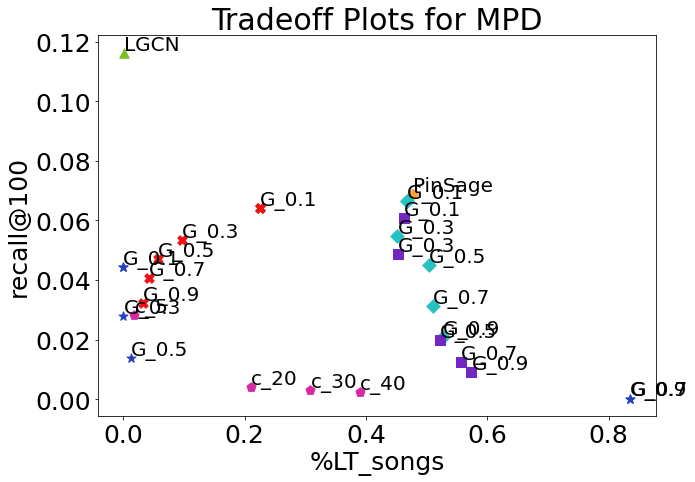

In [70]:
def pareto_plot_MPD(report, dataset, fairness_method, title): 
    redress = load_results(scratch_path, dataset, 'REDRESS', fairness_method, setting='T')
    redress_slice = gamma_prep(redress, 'REDRESS')

    ps_slice = gamma_prep(redress, 'PS')

    lgcn = load_results(scratch_path, dataset, 'LGCN2', fairness_method, 'vanilla')
    lgcn_slice = gamma_prep(lgcn, 'LGCN')

    zerosum = load_results(scratch_path,dataset , 'SR2', fairness_method, setting='T')
    zerosum_slice = gamma_prep(zerosum, "SR")

    x = load_results(scratch_path, dataset, 'XQUAD', fairness_method)
    x_slice = gamma_prep(x, 'XQUAD')

    macr = load_results(scratch_path, dataset, 'MACR', fairness_method, setting='T')
    macr['param'] = macr.param.apply(lambda x: f'c_{x}')
    macr_slice = gamma_prep(macr, 'SR')

    boost = load_results(scratch_path, dataset, 'BOOST', fairness_method, setting="T")
    boost_slice = gamma_prep(boost, 'BOOST')
    
    
    df_dict = {'xQuAD': x_slice, 
           'PinSage': ps_slice, 
           'LGCN': lgcn_slice,
           'REDRESS': redress_slice, 
           'ZeroSum': zerosum_slice, 
           'BOOST': boost_slice, 
          'MACR': macr_slice}
    
    color = ['#ed1111', '#FFA233', '#79C226', '#26C2C2', '#2640C2', '#7226C2', '#D829A0']

    colors = dict(zip(df_dict.keys(), color))
    metric_grps = [
        ['%LT_songs', 'recall@100'], 
        ['LT_song_coverage', 'recall@100']
    ]
    shapes = dict(zip(list(df_dict.keys()), ['X', 'o', "^", "D", "*", 's', 'p']))
    kw = dict(ncol=5, loc="lower center", frameon=True)

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    plt.rcParams.update({'font.size': 25})
    metrics  =metric_grps[0] 
    for name, df in df_dict.items():

        for i in range(len(df)): 
            label = "{}".format(df['param_val'][i]) 
            if str(0.2) in label or  str(0.4) in label or str(0.6) in label or  str(0.8) in label: 
                continue
            if str(10) in label or str(25) in label or str(35) in label or str(45) in label: 
                continue
            row = df.iloc[i, :]
            m1, m2 = row[[metrics[0]]],row[[metrics[1]]]
            if i == 0: 
                ax.scatter(m1,m2 , marker = shapes[name], s=90, color = colors[name], label = name)
            if name == 'LGCN' or name == 'PinSage':
                ax.annotate(name, xy=(m1, m2), xytext=(m1+ 0.00001, m2+0.001), fontsize=20)
                break
            else: 
                ax.scatter(m1,m2 , marker = shapes[name], s=90, color = colors[name])
                ax.annotate(label, xy=(m1, m2), xytext=(m1+ 0.00005, m2+0.001), fontsize=20)

    ax.set_xlabel(metrics[0], fontsize=25)
    ax.set_ylabel(metrics[1], fontsize=25)

#     ax[0].legend(loc=(-0.20, 0.96)) 
#     fig.legend(**kw)
    ax.set_title(f"Tradeoff Plots for MPD", fontsize=30) 


report = ['param', 'r_precision', 'competition_ndcg','artist_prec', 'sound_homogeneity', 
        "norm_diversity",  'perc_LT', 'LT_item_cvg', 'arid_cvg' ]
scratch_path = '/home/mila/r/rebecca.salganik/scratch/PinSAGE_experiments/FULL_RUNS/'
dataset = 'MPD_Subset'
fairness_method = 'log10'
pareto_plot_MPD(report, dataset, fairness_method, '')




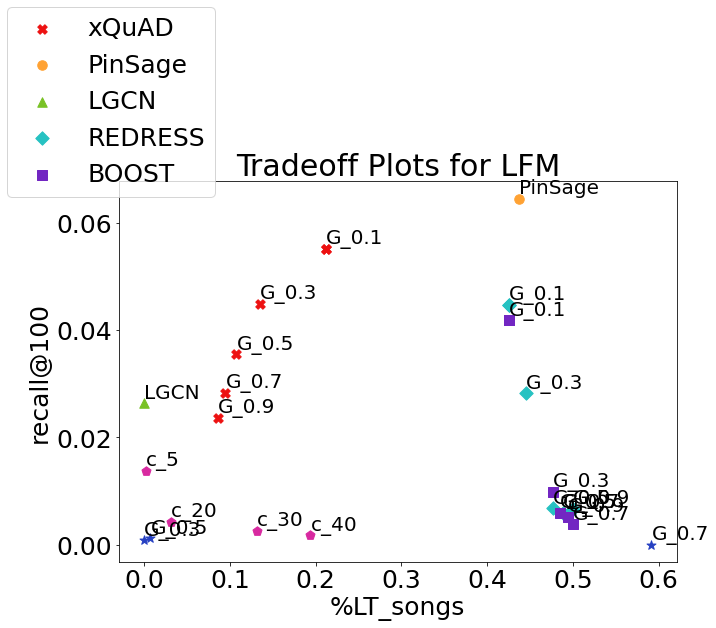

In [75]:
def pareto_plot_LFM(report, dataset, fairness_method, title): 
    
    redress = load_results(scratch_path, dataset, 'REDRESS', fairness_method, setting='T')
    redress_slice = gamma_prep(redress, 'REDRESS')

    ps_slice = gamma_prep(redress, 'PS')

    lgcn = load_results(scratch_path, dataset, 'LGCN2', fairness_method, 'vanilla')
    lgcn_slice = gamma_prep(lgcn, 'LGCN')

    zerosum = load_results(scratch_path, dataset, 'SR2', fairness_method, setting='T')
    zerosum_slice = gamma_prep(zerosum, "SR")

    x = load_results(scratch_path, dataset, 'XQUAD', fairness_method)
    x_slice = gamma_prep(x, 'XQUAD')

    macr = load_results(scratch_path, dataset, 'MACR2', fairness_method, setting='T')
    macr['param'] = macr.param.apply(lambda x: f'c_{x}')
    macr_slice = gamma_prep(macr, 'SR')

    boost = load_results(scratch_path, dataset, 'BOOST', fairness_method, setting="T")
    boost_slice = gamma_prep(boost, 'BOOST')
    
    
    df_dict = {'xQuAD': x_slice, 
           'PinSage': ps_slice, 
           'LGCN': lgcn_slice,
           'REDRESS': redress_slice, 
           'ZeroSum': zerosum_slice, 
           'BOOST': boost_slice, 
          'MACR': macr_slice}
    
    color = ['#ed1111', '#FFA233', '#79C226', '#26C2C2', '#2640C2', '#7226C2', '#D829A0']

    colors = dict(zip(df_dict.keys(), color))
    metric_grps = [
        ['%LT_songs', 'recall@100'], 
        ['LT_song_coverage', 'recall@100']
    ]
    shapes = dict(zip(list(df_dict.keys()), ['X', 'o', "^", "D", "*", 's', 'p']))
    kw = dict(ncol=5, loc="lower center", frameon=True)

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    plt.rcParams.update({'font.size': 25})
    metrics  =metric_grps[0] 
    for name, df in df_dict.items():

        for i in range(len(df)): 
            label = "{}".format(df['param_val'][i]) 
            if str(0.2) in label or  str(0.4) in label or str(0.6) in label or  str(0.8) in label: 
                continue
            if str(10) in label or str(25) in label or str(35) in label or str(45) in label: 
                continue
            row = df.iloc[i, :]
            m1, m2 = row[[metrics[0]]],row[[metrics[1]]]
            if i == 0: 
                ax.scatter(m1,m2 , marker = shapes[name], s=90, color = colors[name], label = name)
            if name == 'LGCN' or name == 'PinSage':
                ax.annotate(name, xy=(m1, m2), xytext=(m1+ 0.00001, m2+0.001), fontsize=20)
                break
            else: 
                ax.scatter(m1,m2 , marker = shapes[name], s=90, color = colors[name])
                ax.annotate(label, xy=(m1, m2), xytext=(m1+ 0.00005, m2+0.001), fontsize=20)

    ax.set_xlabel(metrics[0], fontsize=25)
    ax.set_ylabel(metrics[1], fontsize=25)

    ax.legend(loc=(-0.20, 0.96)) 
#     fig.legend(**kw)
    ax.set_title(f"Tradeoff Plots for LFM", fontsize=30) 


report = ['param', 'r_precision', 'competition_ndcg','artist_prec', 'sound_homogeneity', 
        "norm_diversity",  'perc_LT', 'LT_item_cvg', 'arid_cvg' ]
scratch_path = '/home/mila/r/rebecca.salganik/scratch/PinSAGE_experiments/FULL_RUNS/'
dataset = 'LFM_Subset'
fairness_method = 'log10'
pareto_plot_LFM(report, dataset, fairness_method, '')

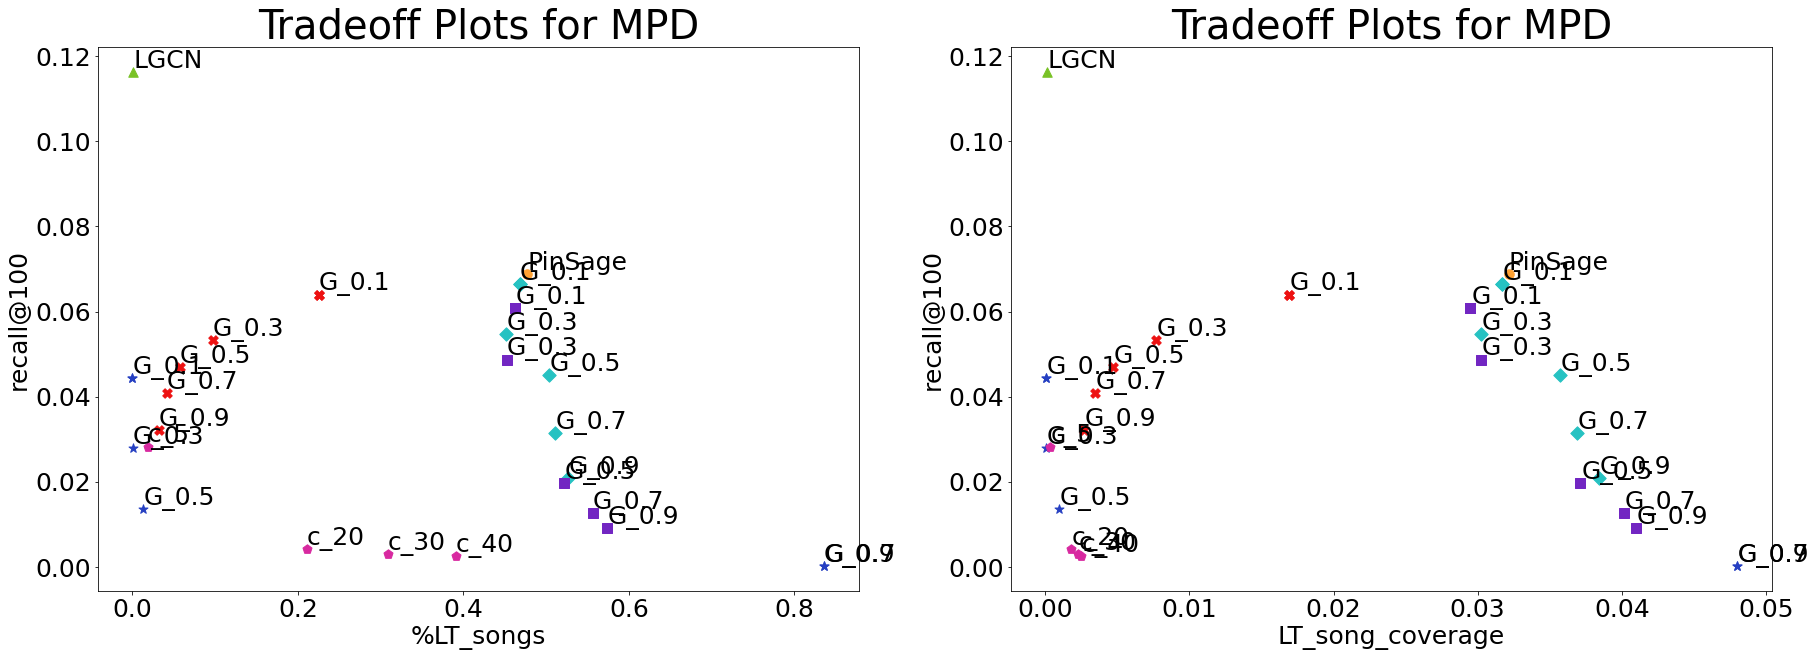

In [31]:
report = ['param', 'r_precision', 'competition_ndcg','artist_prec', 'sound_homogeneity', 
        "norm_diversity",  'perc_LT', 'LT_item_cvg', 'arid_cvg' ]
scratch_path = '/home/mila/r/rebecca.salganik/scratch/PinSAGE_experiments/FULL_RUNS/'
dataset = 'MPD_Subset'
fairness_method = 'log10'


redress = load_results(scratch_path, dataset, 'REDRESS', fairness_method, setting='T')
redress_slice = gamma_prep(redress, 'REDRESS')

ps_slice = gamma_prep(redress, 'PS')

lgcn = load_results(scratch_path, dataset, 'LGCN2', fairness_method, 'vanilla')
lgcn_slice = gamma_prep(lgcn, 'LGCN')

zerosum = load_results(scratch_path, 'MPD_Subset', 'SR2', fairness_method, setting='T')
zerosum_slice = gamma_prep(zerosum, "SR")

x = load_results(scratch_path, 'MPD_Subset', 'XQUAD', fairness_method)
x_slice = gamma_prep(x, 'XQUAD')

macr = load_results(scratch_path, 'MPD_Subset', 'MACR', fairness_method, setting='T')
macr['param'] = macr.param.apply(lambda x: f'c_{x}')
macr_slice = gamma_prep(macr, 'SR')

boost = load_results(scratch_path, 'MPD_Subset', 'BOOST', fairness_method, setting="T")
boost_slice = gamma_prep(boost, 'BOOST')

df_dict = {'xQuAD': x_slice, 
           'PinSage': ps_slice, 
           'LGCN': lgcn_slice,
           'REDRESS': redress_slice, 
           'ZeroSum': zerosum_slice, 
           'BOOST': boost_slice, 
          'MACR': macr_slice}

# color = list(cm.brg(np.linspace(0, 1, 7)))
color = ['#ed1111', '#FFA233', '#79C226', '#26C2C2', '#2640C2', '#7226C2', '#D829A0']

colors = dict(zip(df_dict.keys(), color))
metric_grps = [
    ['%LT_songs', 'recall@100'], 
    ['LT_song_coverage', 'recall@100']
]
shapes = dict(zip(list(df_dict.keys()), ['X', 'o', "^", "D", "*", 's', 'p']))
kw = dict(ncol=5, loc="lower center", frameon=True)

fig, ax = plt.subplots(1, 2, figsize=(30, 10))

plt.rcParams.update({'font.size': 25})
for idx, metrics in enumerate(metric_grps): 
    for name, df in df_dict.items():
        
        for i in range(len(df)): 
            label = "{}".format(df['param_val'][i]) 
            if str(0.2) in label or  str(0.4) in label or str(0.6) in label or  str(0.8) in label: 
                continue
            if str(10) in label or str(25) in label or str(35) in label or str(45) in label: 
                continue
            row = df.iloc[i, :]
            m1, m2 = row[[metrics[0]]],row[[metrics[1]]]
            if i == 0: 
                ax[idx].scatter(m1,m2 , marker = shapes[name], s=90, color = colors[name], label = name)
            if name == 'LGCN' or name == 'PinSage':
                ax[idx].annotate(name, xy=(m1, m2), xytext=(m1+ 0.00001, m2+0.001), fontsize=25)
                break
            else: 
                ax[idx].scatter(m1,m2 , marker = shapes[name], s=90, color = colors[name])
                ax[idx].annotate(label, xy=(m1, m2), xytext=(m1+ 0.00005, m2+0.001), fontsize=25)
               
    ax[idx].set_xlabel(metrics[0], fontsize=25)
    ax[idx].set_ylabel(metrics[1], fontsize=25)
    
#     ax[0].legend(loc=(-0.20, 0.96)) 
#     fig.legend(**kw)
    ax[idx].set_title(f"Tradeoff Plots for MPD", fontsize=40) 

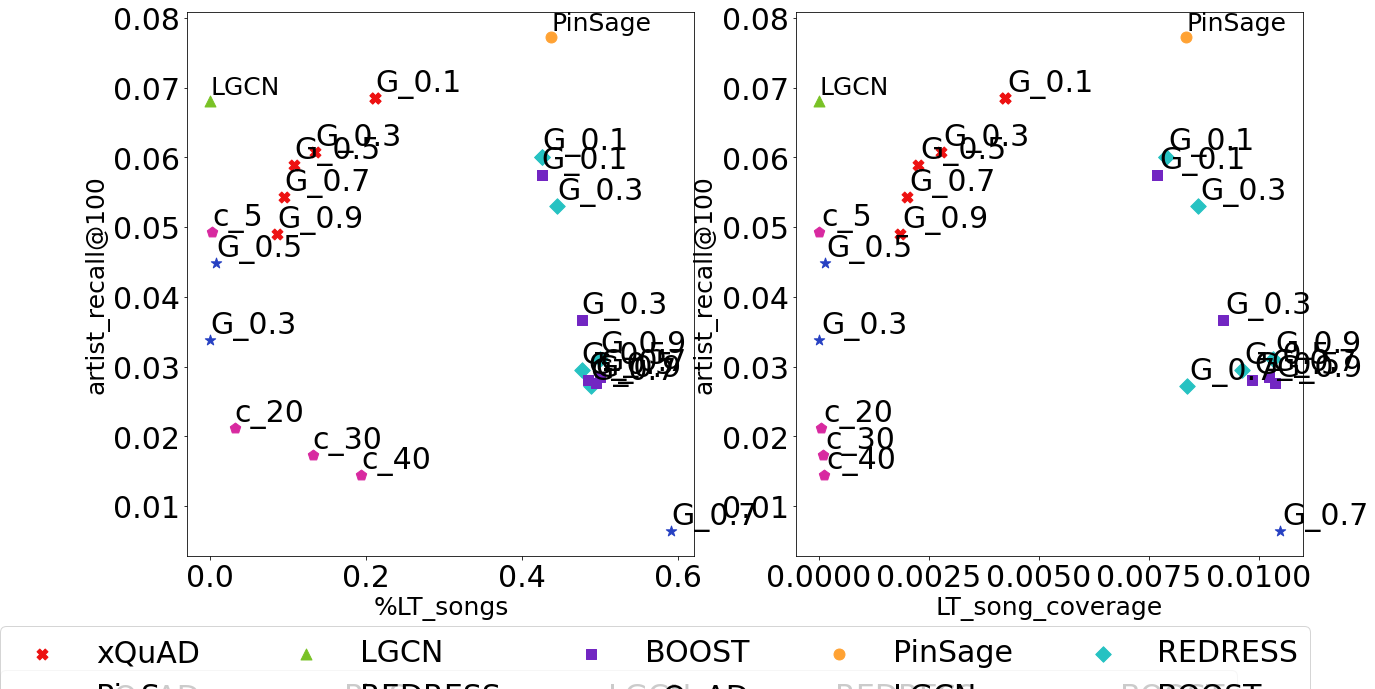

In [51]:
report = ['param', 'r_precision', 'competition_ndcg','artist_prec', 'sound_homogeneity', 
        "norm_diversity",  'perc_LT', 'LT_item_cvg', 'arid_cvg' ]
scratch_path = '/home/mila/r/rebecca.salganik/scratch/PinSAGE_experiments/FULL_RUNS/'
dataset = 'LFM_Subset'
fairness_method = 'log10'


redress = load_results(scratch_path, dataset, 'REDRESS', fairness_method, setting='T')
redress_slice = gamma_prep(redress, 'REDRESS')

ps_slice = gamma_prep(redress, 'PS')

lgcn = load_results(scratch_path, dataset, 'LGCN2', fairness_method, 'vanilla')
lgcn_slice = gamma_prep(lgcn, 'LGCN')

zerosum = load_results(scratch_path, dataset, 'SR2', fairness_method, setting='T')
zerosum_slice = gamma_prep(zerosum, "SR")

x = load_results(scratch_path, dataset, 'XQUAD', fairness_method)
x_slice = gamma_prep(x, 'XQUAD')

macr = load_results(scratch_path, dataset, 'MACR2', fairness_method, setting='T')
macr['param'] = macr.param.apply(lambda x: f'c_{x}')
macr_slice = gamma_prep(macr, 'SR')

boost = load_results(scratch_path, dataset, 'BOOST', fairness_method, setting="T")
boost_slice = gamma_prep(boost, 'BOOST')

df_dict = {'xQuAD': x_slice, 
           'PinSage': ps_slice, 
           'LGCN': lgcn_slice,
           'REDRESS': redress_slice, 
           'ZeroSum': zerosum_slice, 
           'BOOST': boost_slice, 
          'MACR': macr_slice}

# color = list(cm.brg(np.linspace(0, 1, 7)))
color = ['#ed1111', '#FFA233', '#79C226', '#26C2C2', '#2640C2', '#7226C2', '#D829A0']

colors = dict(zip(df_dict.keys(), color))
metric_grps = [
    ['%LT_songs', 'artist_recall@100'], 
    ['LT_song_coverage', 'artist_recall@100']
]
shapes = dict(zip(list(df_dict.keys()), ['X', 'o', "^", "D", "*", 's', 'p']))
kw = dict(ncol=5, loc="upper center", frameon=True)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

plt.rcParams.update({'font.size': 30})
for idx, metrics in enumerate(metric_grps): 
    for name, df in df_dict.items():
        
        for i in range(len(df)): 
            label = "{}".format(df['param_val'][i]) 
            if str(0.2) in label or  str(0.4) in label or str(0.6) in label or  str(0.8) in label: 
                continue
            if str(10) in label or str(25) in label or str(35) in label or str(45) in label: 
                continue
            row = df.iloc[i, :]
            m1, m2 = row[[metrics[0]]],row[[metrics[1]]]
            if i == 0: 
                ax[idx].scatter(m1,m2 , marker = shapes[name], s=120, color = colors[name], label = name)
            if name == 'LGCN' or name == 'PinSage':
                ax[idx].annotate(name, xy=(m1, m2), xytext=(m1+ 0.00001, m2+0.001), fontsize=25)
                break
            else: 
                ax[idx].scatter(m1,m2 , marker = shapes[name], s=120, color = colors[name])
                ax[idx].annotate(label, xy=(m1, m2), xytext=(m1+ 0.00005, m2+0.001), fontsize=30)
               
    ax[idx].set_xlabel(metrics[0], fontsize=25)
    ax[idx].set_ylabel(metrics[1], fontsize=25)
    
#     ax[0].legend(loc=(-0.30, 0.96), ncol=5, fontsize=30) 
    fig.legend(loc=(0.0, -0.05), ncol=5, fontsize=30)
#     ax[idx].set_title(f"Tradeoff Plots for LFM", fontsize=40) 

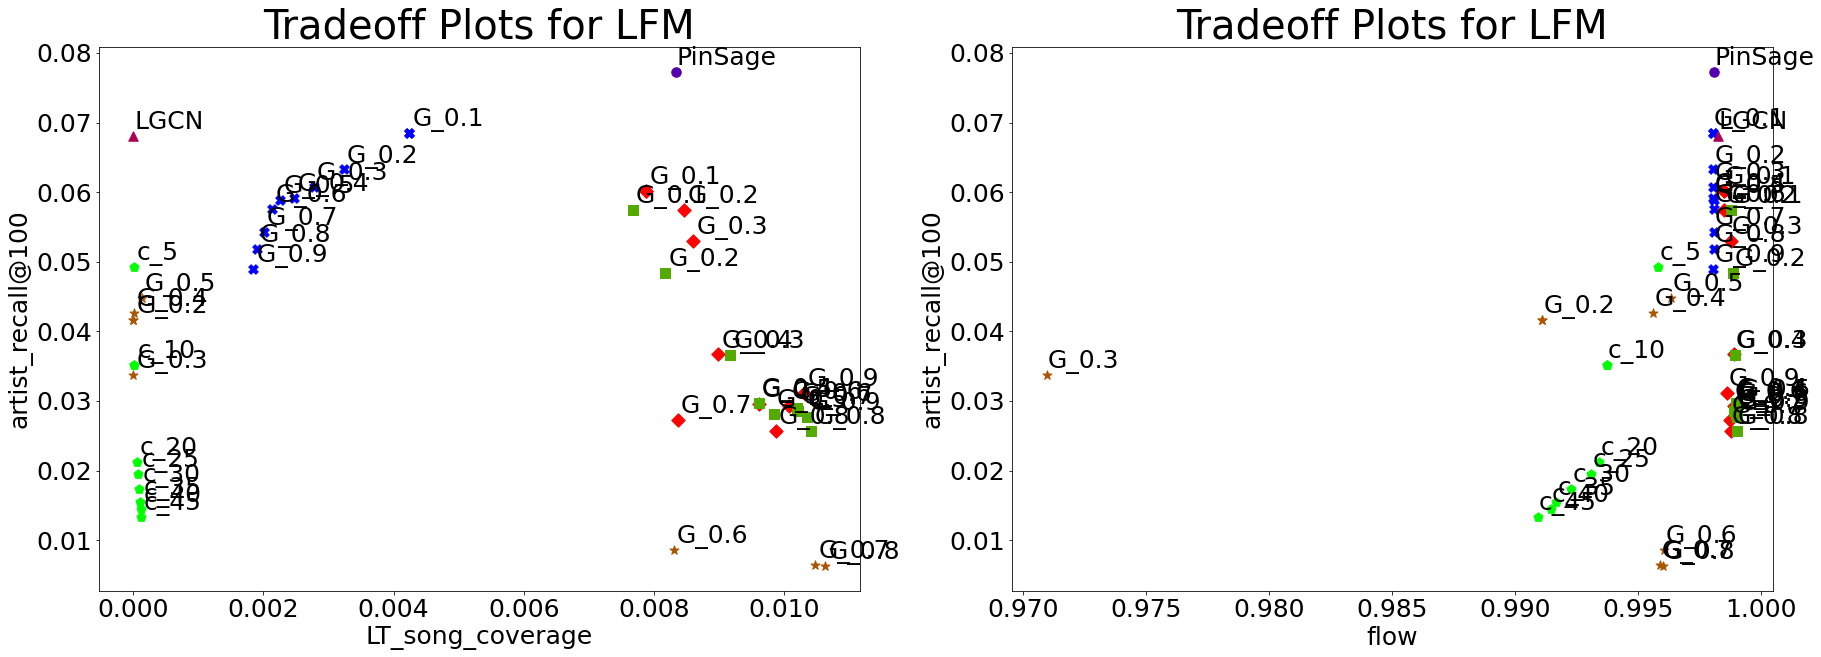

In [22]:
metric_grps = [
    ['LT_song_coverage', 'artist_recall@100'], 
    ['flow', 'artist_recall@100']
]
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

plt.rcParams.update({'font.size': 25})
for idx, metrics in enumerate(metric_grps): 
    for name, df in df_dict.items():
        
        for i in range(len(df)): 
            label = "{}".format(df['param_val'][i]) 
            
            row = df.iloc[i, :]
            m1, m2 = row[[metrics[0]]],row[[metrics[1]]]
            if i == 0: 
                ax[idx].scatter(m1,m2 , marker = shapes[name], s=90, color = colors[name], label = name)
            if name == 'LGCN' or name == 'PinSage':
                ax[idx].annotate(name, xy=(m1, m2), xytext=(m1+ 0.00001, m2+0.001), fontsize=25)
                break
            else: 
                ax[idx].scatter(m1,m2 , marker = shapes[name], s=90, color = colors[name])
                ax[idx].annotate(label, xy=(m1, m2), xytext=(m1+ 0.00005, m2+0.001), fontsize=25)
               
    ax[idx].set_xlabel(metrics[0], fontsize=25)
    ax[idx].set_ylabel(metrics[1], fontsize=25)
    
#     ax[0].legend(loc=(-0.20, 0.96)) 
#     fig.legend(**kw)
    ax[idx].set_title(f"Tradeoff Plots for LFM", fontsize=40) 

In [ ]:
# OLD

In [44]:
df_dict = {'Xquad': x_slice, 
           'PinSage (PS)': ps_slice, 
           'LGCN': lgcn_slice,
           'PS + REDRESS': r_slice, 
           'ScoreReg': sr_slice, 
           'PS + REDRESS + Boost': b_slice}
colors = {'Xquad': 'blue', 
           'PinSage (PS)': 'violet', 
           'LGCN': 'green',
           'PS + REDRESS': 'orange', 
           'ScoreReg': 'red', 
           'PS + REDRESS + Boost': 'purple'}

shapes = dict(zip(list(df_dict.keys()), ['X', 'o', "^", "D", "*", 's']))
kw = dict(ncol=5, loc="lower center", frameon=True)



NameError: name 'r_slice' is not defined

In [11]:
# report = ['r_precision', 'competition_ndcg','artist_prec', 'sound_homogeneity', 
#         "norm_diversity",  'perc_LT', 'LT_item_cvg', 'arid_cvg' ]
# scratch_path = '/home/mila/r/rebecca.salganik/scratch/PinSAGE_experiments/FULL_RUNS/'
# dataset = 'LFM_Subset'
# fairness_method = 'log10'

# ps, _ = load_results(scratch_path, dataset, 'REDRESS', fairness_method)
# ps_slice = gamma_prep(ps, 'PS')

# lgcn, _ = load_results(scratch_path, dataset, 'LGCN', fairness_method)
# lgcn_slice = gamma_prep(lgcn, 'LGCN')

# sr, _ = load_results(scratch_path, dataset, 'SR', fairness_method)
# sr_slice = gamma_prep(sr, 'SR')

# r, _ = load_results(scratch_path, dataset, 'REDRESS', fairness_method)
# r_slice = gamma_prep(r, 'REDRESS')

# x, _ = load_results(scratch_path, dataset, 'XQUAD', fairness_method)
# x_slice = gamma_prep(x, 'XQUAD')

# b, _ = load_results(scratch_path, dataset, 'BOOST', fairness_method)
# b_slice = gamma_prep(b, 'BOOST')

# b, _ = load_results(scratch_path, dataset, 'BOOST', fairness_method)
# b_slice = gamma_prep(b, 'BOOST')

ValueError: too many values to unpack (expected 2)